## Fitting Peak Flow Data from Russian River Basins to a Pearson-III Distribution Using the Method of Moments to Quantify Extremeness of Years
by Arman Omidvar

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import pearson3
import matplotlib.pyplot as plt
from scipy.special import gammaln


## Calculate Method of Moments estimator for pearson-III distribution 

### Calculate sample skew and weighted skew

We need to calculate weighted skew according to USGS Bulletin 17C.

We do this by computing the sample skew from our data, and adjusting given the regional skew.

We find regional skew to be -0.555  
We find regional MSE of regional skew to be 0.13  

According to table 1 of Regional skew for California, and flood frequency for selected sites in the Sacramento-San Joaquin River Basin, based on data through water year 2006  
By: Charles Parrett, Andrea Veilleux, J.R. Stedinger, N.A. Barth, Donna L. Knifong, and J.C. Ferris

For station MSE, we use the approximate variance of the sample skewness i.e. $MSE_{station} \approx Var(G_1) \approx \frac{6}{n}$

In [10]:
def sample_skew(peak_flows):
    """
    Calculate the station skew for a basin based on a sample of peak flow measurements.
    """
    n = len(peak_flows)
    log_peak_flows = np.log10(peak_flows)
    std = np.std(log_peak_flows, ddof=1)
    mean = np.mean(log_peak_flows)

    return (np.sum((log_peak_flows - mean) ** 3) * n) / ((n - 1) * (n - 2) * (std ** 3))


def weighted_skew(peak_flows, G_reg, MSE_reg):
    "calculates the weighted skew according to USGS Bulletin 17C"
    G_sta = sample_skew(peak_flows)
    G_reg = G_reg
    MSE_reg = MSE_reg
    n = len(peak_flows)
    MSE_sta = 6 / n

    return ((G_sta/MSE_sta) + (G_reg/MSE_reg)) / ((1/MSE_sta) + (1/MSE_reg))

### Estimate mu and sigma using method of moments

According to Bulletin #17C, the pdf of log-Pearson type III distribution is:  

$f(x \mid \tau, \alpha, \beta)
= \frac{1}{|\beta| \, \Gamma(\alpha)}
\left( \frac{x - \tau}{\beta} \right)^{\alpha - 1}
\exp\!\left[-\,\frac{x - \tau}{\beta}\right]$

We can already calculated the third moment using the weightedSkew function, as well as the MOM estimate of alpha given the third moment using the pearsonIII_alpha_estimate

The first and second moments are just the mean and standard deviation of the logged peak flow values

Now we calculate the MOM estimates of $\alpha$, $\beta$ and $\tau$

In [11]:
def pearsonIII_alpha_estimate(G_weighted):
    """
    Compute the MOM estimate of the alpha parameter for a Pearson-III distribution based on the weighted skew.
    """
    alpha = (4 / (G_weighted ** 2))
    return alpha

def pearsonIII_beta_estimate(sample_skew, standard_error, alpha_hat):
    """
    Compute the MOM estimate of the beta parameter for a Pearson-III distribution.
    """
    beta_hat = np.sign(sample_skew) * (standard_error ** 2 / alpha_hat) ** 0.5
    return beta_hat

def pearsonIII_tau_estimate(mean_log_peak_flows, beta_hat, alpha_hat):
    """
    Compute the MOM estimate of the tau parameter for a Pearson-III distribution.
    """
    tau_hat = mean_log_peak_flows - (alpha_hat * beta_hat)
    return tau_hat

## Fitting our distribution

Now that we have estimates for all the parameters, we can fit and plot our distribution for each basin

Basin: Calpella
alpha_hat: 66.86964233116761, beta_hat: -0.02405150278746636, tau_hat: 5.217637769723737


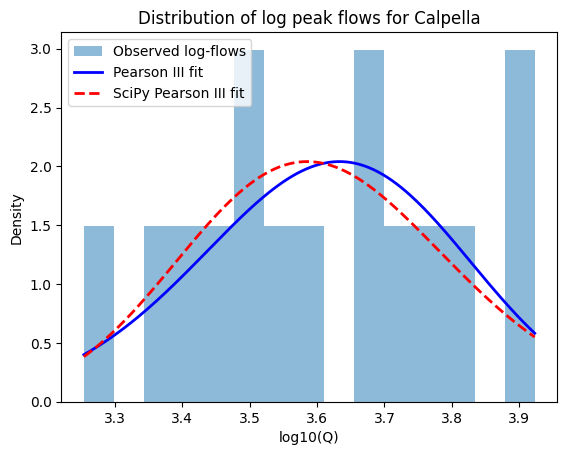

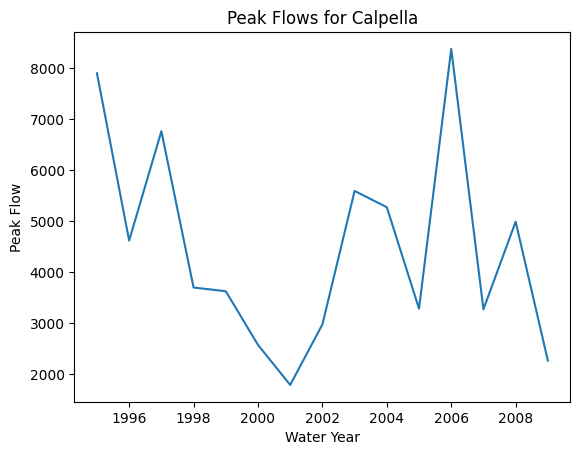

Basin: Guerneville
alpha_hat: 60.22655591396036, beta_hat: 0.025392880579212674, tau_hat: 3.05574935027684


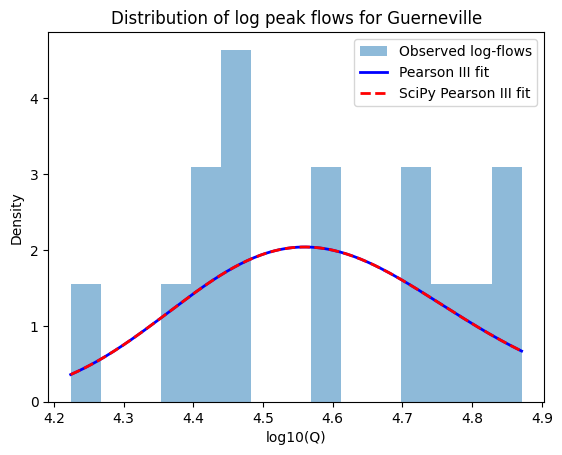

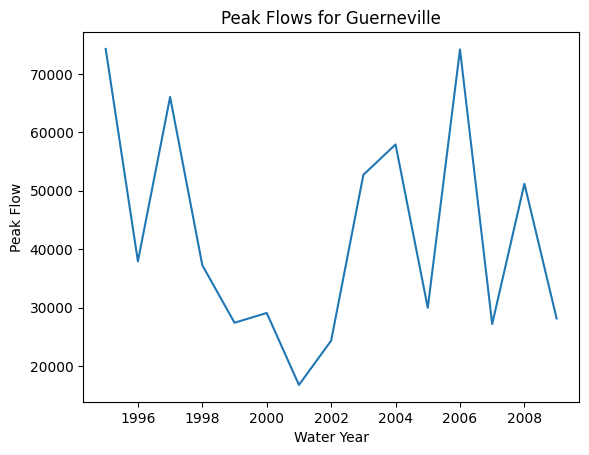

Basin: Hopland
alpha_hat: 29.593173520333924, beta_hat: 0.03826570791994984, tau_hat: 2.9194476939394463


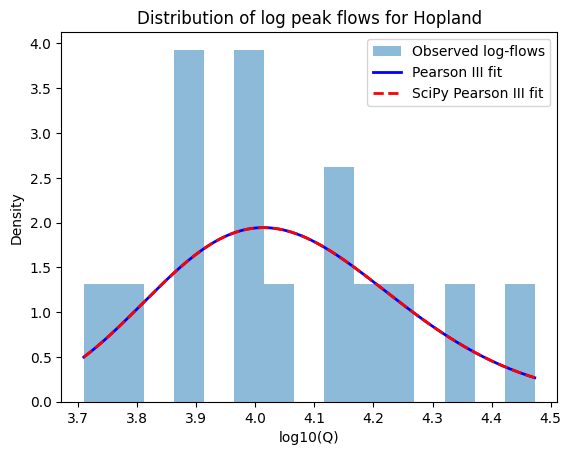

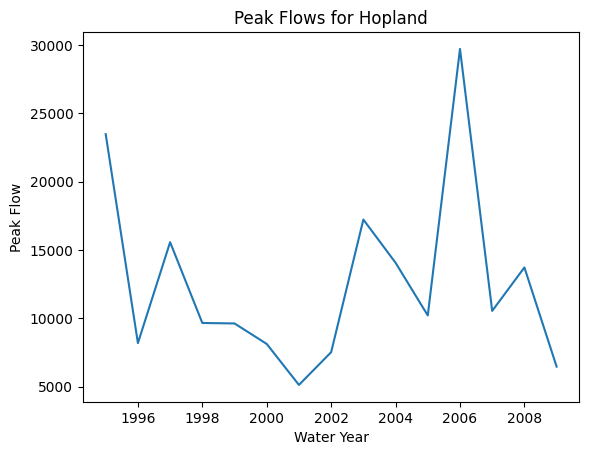

Basin: Warm Springs
alpha_hat: 42.325322024427585, beta_hat: 0.03012411543127353, tau_hat: 2.596513382465039


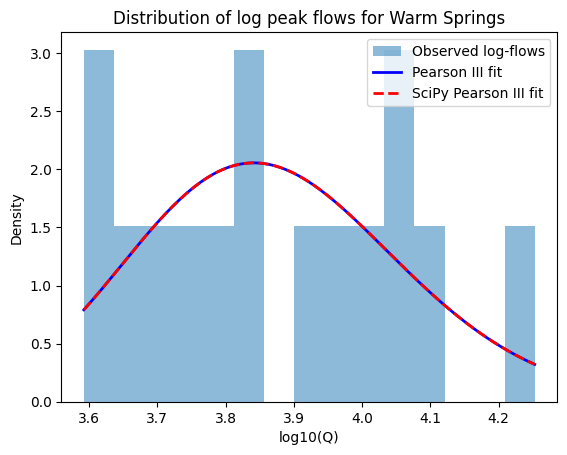

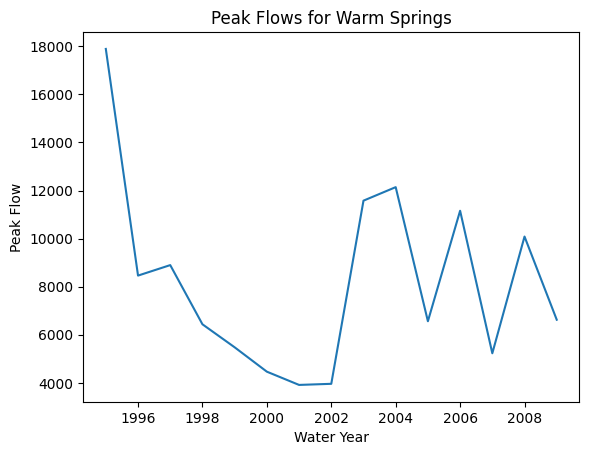

In [23]:
calpella_peak_flows = pd.read_csv('russian_river_peak_flows/Calpella.csv')
guerneville_peak_flows = pd.read_csv('russian_river_peak_flows/Guerneville.csv')
hopland_peak_flows = pd.read_csv('russian_river_peak_flows/Hopland.csv')
warmsprings_peak_flows = pd.read_csv('russian_river_peak_flows/Warm.csv')

peak_flows = {'Calpella': calpella_peak_flows['Calpella Gage FLOW'].values,
              'Guerneville': guerneville_peak_flows['Guerneville Gage FLOW'].values,
              'Hopland': hopland_peak_flows['Hopland Gage FLOW'].values,
              'Warm Springs': warmsprings_peak_flows['Warm Springs Dam Inflow FLOW'].values}


extreme_years = pd.DataFrame()
extreme_years['water_year'] = calpella_peak_flows['water_year']

def pearson3_pdf(x, alpha, beta, tau):
    x = np.asarray(x, dtype=float)

    if alpha <= 0 or beta == 0:
        return np.full_like(x, np.nan)

    z = (x - tau) / beta
    mask = z > 0

    out = np.zeros_like(x, dtype=float)
    logpdf = -np.log(abs(beta)) - gammaln(alpha) + (alpha - 1)*np.log(z[mask]) - z[mask]
    out[mask] = np.exp(logpdf)
    return out

for basin in peak_flows.keys():
    basin_peak_flows = peak_flows[basin]
    G_station = sample_skew(basin_peak_flows)
    G_weighted = weighted_skew(basin_peak_flows, G_reg=0.333, MSE_reg=0.13)

    log_flows = np.log10(basin_peak_flows)
    mean_log_flows = np.mean(log_flows)
    std_log_flows = np.std(log_flows, ddof=1)

    alpha_hat = pearsonIII_alpha_estimate(G_weighted)
    beta_hat = pearsonIII_beta_estimate(G_station, std_log_flows, alpha_hat)
    tau_hat = pearsonIII_tau_estimate(mean_log_flows, beta_hat, alpha_hat)

    print(f'Basin: {basin}')
    print(f'alpha_hat: {alpha_hat}, beta_hat: {beta_hat}, tau_hat: {tau_hat}')

    dist = pearson3(G_weighted, loc=mean_log_flows, scale=std_log_flows)
    x = np.linspace(min(log_flows), max(log_flows), 200)
    scipy_pdf_vals = dist.pdf(x)
    my_pdf_vals = pearson3_pdf(x, alpha_hat, beta_hat, tau_hat)

    extreme_years[basin] = 1 - dist.cdf(np.log10(basin_peak_flows))

    plt.hist(log_flows, bins=15, density=True, alpha=0.5, label='Observed log-flows')
    plt.plot(x, my_pdf_vals, 'b-', lw=2, label='Pearson III fit')
    plt.plot(x, scipy_pdf_vals, 'r--', lw=2, label='SciPy Pearson III fit')
    plt.xlabel('log10(Q)')
    plt.ylabel('Density')
    plt.title(f'Distribution of log peak flows for {basin}')
    plt.legend()
    plt.show()

    plt.plot(range(1995, 2010), basin_peak_flows)
    plt.xlabel('Water Year')
    plt.ylabel('Peak Flow')
    plt.title(f'Peak Flows for {basin}')
    plt.show()

## Quantify Extremeness

For each year, we find $\Pr(\text{random peak flow} \geq \text{the peak flow from that year})$ using the CDF

In [13]:
extreme_years.to_csv('extreme_years_russian_river.csv', index=False)
print(extreme_years)

    water_year  Calpella  Guerneville   Hopland  Warm Springs
0         1995  0.077037     0.079124  0.071123      0.033683
1         1996  0.374812     0.495742  0.736864      0.369740
2         1997  0.132471     0.119368  0.238961      0.329908
3         1998  0.566969     0.511126  0.605025      0.608328
4         1999  0.584480     0.767335  0.608070      0.742605
5         2000  0.843461     0.722728  0.742595      0.875494
6         2001  0.972349     0.974790  0.962731      0.931986
7         2002  0.747369     0.844635  0.796381      0.927876
8         2003  0.234402     0.236495  0.183431      0.162084
9         2004  0.273906     0.180896  0.304668      0.139821
10        2005  0.669255     0.698985  0.558313      0.591058
11        2006  0.061681     0.079507  0.030369      0.181153
12        2007  0.672295     0.773151  0.531367      0.777202
13        2008  0.314114     0.255792  0.321909      0.240907
14        2009  0.906408     0.747804  0.883116      0.582588
